# Clustering Analysis – EastWest Airlines Dataset

This notebook contains my clustering project. All results are **shown below in the notebook**
and also **saved inside the `output/` folder** for reference.

## Imports and output folder setup

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram

for folder in ["output", "output/plots", "output/labels", "output/reports", "output/processed"]:
    os.makedirs(folder, exist_ok=True)

print("Output folders created successfully.")


Output folders created successfully.


## Loading the dataset

In [2]:

def load_dataset(path="data/raw/EastWestAirlines.xlsx"):
    if not os.path.exists(path):
        raise FileNotFoundError("Dataset not found")

    excel = pd.ExcelFile(path)
    for sheet in excel.sheet_names:
        df = pd.read_excel(path, sheet_name=sheet)
        numeric = df.select_dtypes(include="number")
        if numeric.shape[1] > 0:
            return df, numeric

    raise ValueError("No numeric data found")

df_raw, df_numeric = load_dataset()

print("Dataset shape:", df_numeric.shape)
display(df_numeric.head())


Dataset shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


## Data preprocessing

In [3]:

def preprocess_data(df_numeric, save_path="output/processed/cleaned_data.csv"):
    df_clean = df_numeric.drop_duplicates()
    df_clean = df_clean.fillna(df_clean.median())

    lower = df_clean.quantile(0.01)
    upper = df_clean.quantile(0.99)
    df_clean = df_clean.clip(lower, upper, axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean)

    pd.DataFrame(X_scaled, columns=df_clean.columns).to_csv(save_path, index=False)
    print("Cleaned and scaled data saved to:", save_path)

    return df_clean, X_scaled

df_clean, X_scaled = preprocess_data(df_numeric)
print("Scaled data shape:", X_scaled.shape)


Cleaned and scaled data saved to: output/processed/cleaned_data.csv
Scaled data shape: (3999, 12)


## K-Means clustering

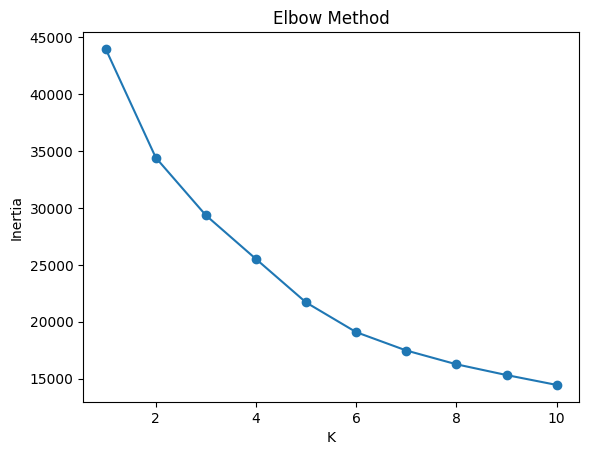

Best K selected: 2
K-Means labels saved.
Silhouette score: 0.29590415878801335


In [4]:

def run_kmeans(X_scaled, df_original):
    inertia = []
    K = range(1, 11)

    for k in K:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        model.fit(X_scaled)
        inertia.append(model.inertia_)

    plt.figure()
    plt.plot(K, inertia, marker="o")
    plt.title("Elbow Method")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.savefig("output/plots/kmeans_elbow.png")
    plt.show()

    sil_scores = {}
    for k in range(2, 11):
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X_scaled)
        sil_scores[k] = silhouette_score(X_scaled, labels)

    best_k = max(sil_scores, key=sil_scores.get)
    print("Best K selected:", best_k)

    model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)

    out = df_original.copy()
    out["KMeans_Label"] = labels
    out.to_csv("output/labels/kmeans_labels.csv", index=False)

    print("K-Means labels saved.")
    print("Silhouette score:", sil_scores[best_k])

    return best_k, labels, sil_scores[best_k]

kmeans_result = run_kmeans(X_scaled, df_numeric)


## Hierarchical clustering

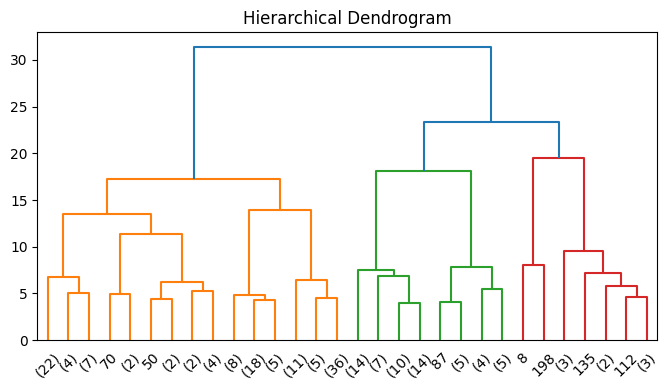

Best number of clusters: 5
Hierarchical labels saved.
Silhouette score: 0.27284791192628655


In [5]:

def run_hierarchical(X_scaled, df_original):
    Z = linkage(X_scaled[:200], method="ward")

    plt.figure(figsize=(8, 4))
    dendrogram(Z, truncate_mode="lastp", p=30)
    plt.title("Hierarchical Dendrogram")
    plt.savefig("output/plots/hierarchical_dendrogram.png")
    plt.show()

    sil_scores = {}
    for k in range(2, 11):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X_scaled)
        sil_scores[k] = silhouette_score(X_scaled, labels)

    best_k = max(sil_scores, key=sil_scores.get)
    print("Best number of clusters:", best_k)

    model = AgglomerativeClustering(n_clusters=best_k)
    labels = model.fit_predict(X_scaled)

    out = df_original.copy()
    out["Hierarchical_Label"] = labels
    out.to_csv("output/labels/hierarchical_labels.csv", index=False)

    print("Hierarchical labels saved.")
    print("Silhouette score:", sil_scores[best_k])

    return best_k, labels, sil_scores[best_k]

hierarchical_result = run_hierarchical(X_scaled, df_numeric)


## DBSCAN clustering

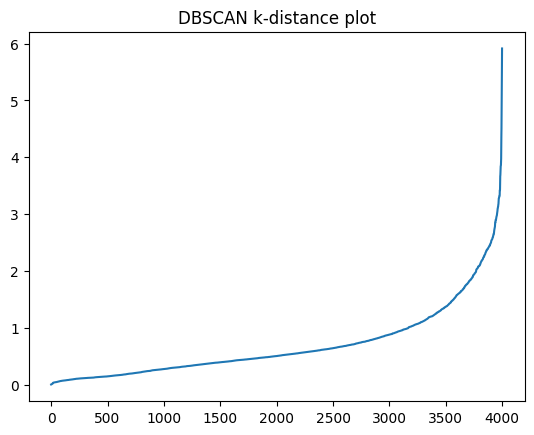

Chosen eps value: 1.5784636270279333
Clusters found: 5
Noise points: 334
Silhouette score: 0.22860160495265652


In [6]:

def run_dbscan(X_scaled, df_original, min_samples=5):
    nbrs = NearestNeighbors(n_neighbors=min_samples-1).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)

    eps = np.percentile(np.sort(distances[:, -1]), 90)

    plt.figure()
    plt.plot(np.sort(distances[:, -1]))
    plt.title("DBSCAN k-distance plot")
    plt.savefig("output/plots/dbscan_kdist.png")
    plt.show()

    print("Chosen eps value:", eps)

    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X_scaled)

    out = df_original.copy()
    out["DBSCAN_Label"] = labels
    out.to_csv("output/labels/dbscan_labels.csv", index=False)

    n_clusters = len(set(labels) - {-1})
    n_noise = sum(labels == -1)

    print("Clusters found:", n_clusters)
    print("Noise points:", n_noise)

    mask = labels != -1
    sil = silhouette_score(X_scaled[mask], labels[mask]) if n_clusters >= 2 else None
    print("Silhouette score:", sil)

    return eps, labels, sil

dbscan_result = run_dbscan(X_scaled, df_numeric)


## PCA visualization

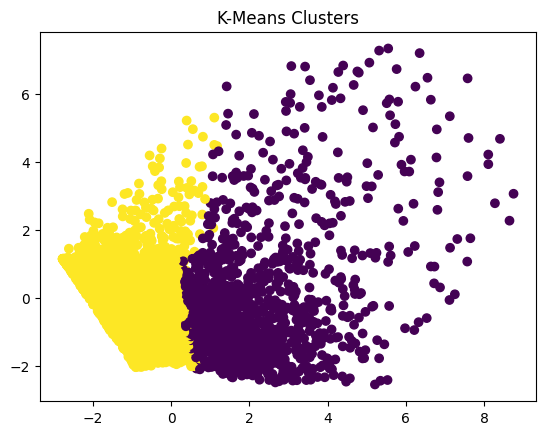

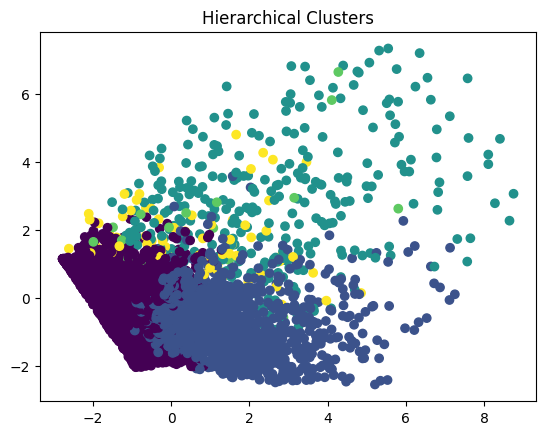

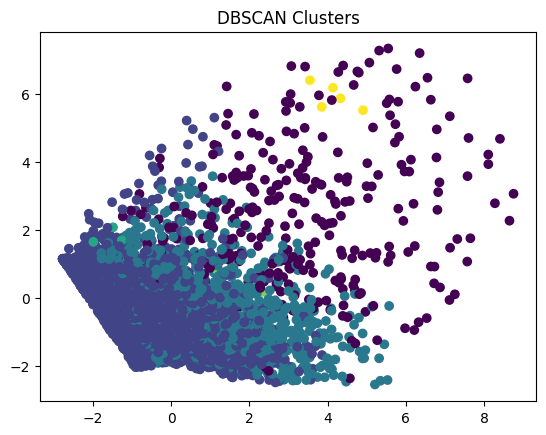

In [7]:

def visualize_clusters(X_scaled, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis")
    plt.title(title)
    plt.show()

visualize_clusters(X_scaled, kmeans_result[1], "K-Means Clusters")
visualize_clusters(X_scaled, hierarchical_result[1], "Hierarchical Clusters")
visualize_clusters(X_scaled, dbscan_result[1], "DBSCAN Clusters")


## Final report

In [8]:

report_path = "output/reports/final_report.txt"
with open(report_path, "w") as f:
    f.write(f"K-Means Silhouette: {kmeans_result[2]:.4f}\n")
    f.write(f"Hierarchical Silhouette: {hierarchical_result[2]:.4f}\n")
    f.write(f"DBSCAN Silhouette: {dbscan_result[2]}\n")

print("Final report saved to:", report_path)


Final report saved to: output/reports/final_report.txt


## Conclusion

The outputs are visible directly in this notebook and also saved
inside the output folder. This makes it easier to verify results
and reuse them later.